# Download data on Zenodo: https://zenodo.org/records/11150343

# Read the data

In [1]:
import pyreadr
import os
os.environ['USE_PYGEOS'] = '0'
os.environ['PROJ_LIB'] = '/opt/conda/share/proj/'
import geopandas as gpd
import numpy as np

gdf = gpd.read_file('extracted_points_wgs84.gpkg')
# Load the unified EU boundary shapefile (GeoPackage format)
eu_boundary = gpd.read_file(f'{path}/eu_boundary.gpkg', driver='GPKG') # data in the data folder

# Extract the geometry of the EU boundary from the GeoDataFrame
eu_polygon = eu_boundary.unary_union  # This combines all parts of the EU into a single shape

# Function to check if a point is in the EU
def check_point_in_eu(row):
    point = row['geometry']
    return 1 if eu_polygon.contains(point) else 0

# # Apply the function to each row in the DataFrame
gdf['eu'] = gdf.apply(check_point_in_eu, axis=1)

mask = gdf['eu'] == 1

# Check the data distribution of the time series for assessment

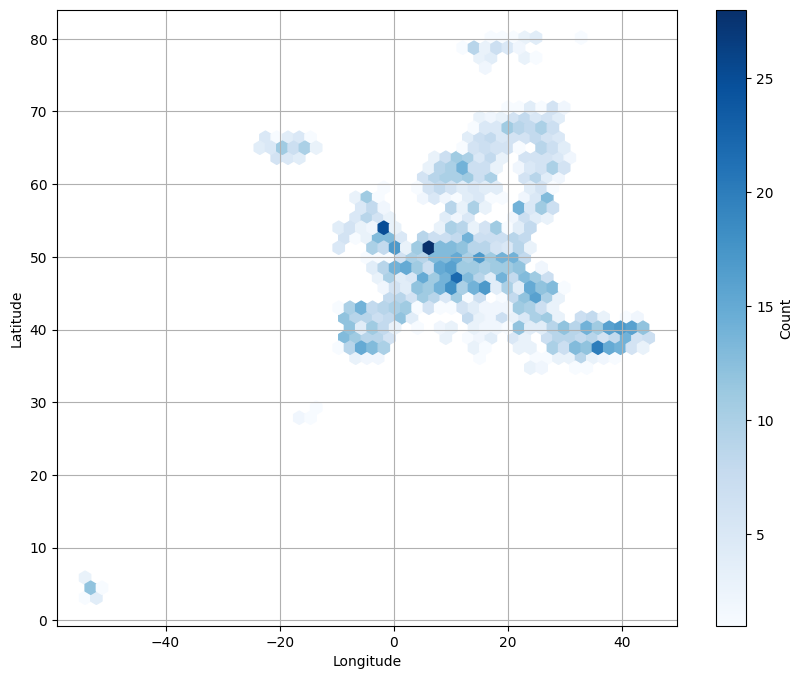

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf = gdf.loc[mask]

# Extract latitude and longitude from the geometry
gdf['lon'] = gdf.geometry.x
gdf['lat'] = gdf.geometry.y

plt.figure(figsize=(10, 8))
hb = plt.hexbin(
    gdf['lon'], gdf['lat'], gridsize=50, cmap='Blues', mincnt=1
)

# Add color bar
cb = plt.colorbar(hb, label='Count')

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.title('Spatial distribution of tim')
plt.savefig('spatial_distribution.pdf', format="pdf", bbox_inches="tight")

plt.grid(True)
plt.show()

# Read in data, prepare functions

In [3]:
strata = gpd.read_file('extracted_points_wgs84.gpkg')['Stratum'].to_numpy()
strata = strata[mask]

group_1c = (strata == 1)
group_ge2c = (strata == 2)
group_0c = (strata > 2)

In [4]:
count_1c = np.sum(group_1c.astype(int))
print(count_1c)
count_ge2c = np.sum(group_ge2c.astype(int))
print(count_ge2c)
count_0c = np.sum(group_0c.astype(int))
print(count_0c)
print(count_1c+count_ge2c+count_0c)
print(strata.shape)

126
95
2525
2746
(2746,)


In [5]:
bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermal']
merged_agg_data_1c = np.full((count_1c*7,156), np.nan, dtype=np.double) 
merged_agg_data_ge2c = np.full((count_ge2c*7,156), np.nan, dtype=np.double) 
merged_agg_data_0c = np.full((count_0c*7,156), np.nan, dtype=np.double) 
merged_ARCO_data_1c = np.empty((count_1c*7,156), dtype=np.double) 
merged_ARCO_data_ge2c = np.empty((count_ge2c*7,156), dtype=np.double) 
merged_ARCO_data_0c = np.empty((count_0c*7,156), dtype=np.double) 

data = pyreadr.read_r('clear_agg.rds')[None].to_numpy()
data = data[mask]
clear_1c = data[group_1c]
clear_ge2c = data[group_ge2c]
clear_0c = data[group_0c]
mask_1c = (clear_1c == 1)
mask_ge2c = (clear_ge2c == 1)
mask_0c = (clear_0c == 1)
np.save('clear_1c', clear_1c)
np.save('clear_ge2c', clear_ge2c)
np.save('clear_0c', clear_0c)


for i, band in enumerate(bands):
    # Dividing by the scaling 250
    data = pyreadr.read_r(f'{band}_agg.rds')[None].to_numpy()/250.
    data = data[mask]
    data_1c = data[group_1c]
    data_ge2c = data[group_ge2c]
    data_0c = data[group_0c]
    
    merged_agg_data_1c[i*count_1c:(i+1)*count_1c,:][mask_1c] = data_1c[mask_1c]
    merged_agg_data_ge2c[i*count_ge2c:(i+1)*count_ge2c,:][mask_ge2c] = data_ge2c[mask_ge2c]
    merged_agg_data_0c[i*count_0c:(i+1)*count_0c,:][mask_0c] = data_0c[mask_0c]
    
np.save('merged_agg_data_1c', merged_agg_data_1c)
np.save('merged_agg_data_ge2c', merged_agg_data_ge2c)
np.save('merged_agg_data_0c', merged_agg_data_0c)


In [6]:
font_size = 18

import matplotlib.pyplot as plt
import sys
import numpy as np
import os
import pandas as pd
import seaborn as sns
sys.path.insert(0, os.path.abspath('../../'))
# from skmap.data import toy
from skmap.io import process
import importlib
import time
importlib.reload(process)
from tqdm.notebook import tqdm
from scipy.signal import savgol_coeffs
plt.rcParams.update({'font.size': 14})
import mpl_scatter_density
from matplotlib.colors import LinearSegmentedColormap
from sklearn.linear_model import LinearRegression

In [7]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(0, 0, 1), (0, 1, 0), (1, 1, 0), (1, 0, 0)]  # Blue to green to yellow to red
n_bins = [100, 100, 100, 100]  # Number of bins for each color
cmap_name = 'custom_colormap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=np.max(n_bins))

import matplotlib.lines as mlines


def add_nan_elements(A, fraction_of_nan):
    B = np.copy(A)
    non_nan_indices = np.where(~np.isnan(A))
    total_non_nan_elements = len(non_nan_indices[0])
    nan_elements_count = int(total_non_nan_elements * fraction_of_nan)
    chosen_indices = np.random.choice(total_non_nan_elements, nan_elements_count, replace=False)
    nan_indices = (non_nan_indices[0][chosen_indices], non_nan_indices[1][chosen_indices], non_nan_indices[2][chosen_indices])
    B[nan_indices] = np.nan
    return B

def get_SWA_weights(att_env, att_seas, season_size, n_imag):
    conv_mat_row = np.zeros((n_imag))
    base_func = np.zeros((season_size,))
    period_y = season_size/2.0
    slope_y = att_seas/10/period_y
    for i in np.arange(season_size):
        if i <= period_y:
            base_func[i] = -slope_y*i
        else:
            base_func[i] = slope_y*(i-period_y)-att_seas/10
    # Compute the envelop to attenuate temporarly far images
    env_func = np.zeros((n_imag,))
    delta_e = n_imag
    slope_e = att_env/10/delta_e
    for i in np.arange(delta_e):
        env_func[i] = -slope_e*i
        conv_mat_row = 10.0**(np.resize(base_func,n_imag) + env_func)
    return conv_mat_row

def compute_RMSE(out_vec, data, data_ref):
    mask_cmp = np.isnan(data) & ~np.isnan(data_ref)
    for out_i in out_vec:
        mask_cmp = mask_cmp & ~np.isnan(out_i)

    rerr = []
    for out_i in out_vec:
        diff = np.array(data_ref[mask_cmp] - out_i[mask_cmp])
        RMSE = np.sqrt(np.mean((diff) ** 2))
        rerr.append(RMSE)
    return rerr

def compute_CVRMSE(out_vec, data, data_ref):
    mask_cmp = np.isnan(data) & ~np.isnan(data_ref)
    for out_i in out_vec:
        mask_cmp = mask_cmp & ~np.isnan(out_i)

    rerr = []
    for out_i in out_vec:
        diff = np.array(data_ref[mask_cmp] - out_i[mask_cmp])
        RMSE = np.sqrt(np.mean((diff) ** 2))
        mean_ref = np.mean(np.array(data_ref[mask_cmp], dtype=np.double))
        CVRMSE = RMSE / mean_ref
        rerr.append(CVRMSE)
    return rerr

def standard_LI(data):
    out_data = data.copy()
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            prev_avail_pix = -1
            next_avail_pix = -1
            for k in range(data.shape[2]):
                if np.isnan(data[i,j,k]):
                    if (prev_avail_pix>-1) and (next_avail_pix>-1):
                        delta_x = next_avail_pix - prev_avail_pix
                        delta_y = data[i,j,next_avail_pix] - data[i,j,prev_avail_pix]
                        m = delta_y / float(delta_x)
                        out_data[i,j,k] = data[i,j,prev_avail_pix] + m * float(k - prev_avail_pix)
                else:
                    prev_avail_pix = k
                    for n in range(k+1, data.shape[2]):
                        if ~np.isnan(data[i,j,n]):
                            next_avail_pix = n
                            break
    return out_data

def compute_R_sq(out_vec, data, data_ref):
    mask_cmp = np.isnan(data) & ~np.isnan(data_ref)
    for out_i in out_vec:
        mask_cmp = mask_cmp & ~np.isnan(out_i)

    rerr = []
    for out_i in out_vec:
        corr_matrix = np.corrcoef(data_ref[mask_cmp], out_i[mask_cmp])
        corr = corr_matrix[0,1]
        R_sq = corr**2
        rerr.append(R_sq)
    return rerr

def compute_RMSE_std(out_vec, data, data_ref):
    mask_cmp = np.isnan(data) & ~np.isnan(data_ref)
    for out_i in out_vec:
        mask_cmp = mask_cmp & ~np.isnan(out_i)

    rerr = []
    for out_i in out_vec:
        diff = np.array(data_ref[mask_cmp] - out_i[mask_cmp])
        RMSE = np.sqrt(np.mean((diff) ** 2))
        std_ref = np.std(np.array(data_ref[mask_cmp], dtype=np.double))
        RMSE_std = RMSE / std_ref
        rerr.append(RMSE_std)
    return rerr

def compute_CCC(out_vec, data, data_ref):
    mask_cmp = np.isnan(data) & ~np.isnan(data_ref)
    for out_i in out_vec:
        mask_cmp = mask_cmp & ~np.isnan(out_i)

    rerr = []
    for out_i in out_vec:
        x = data_ref[mask_cmp]
        y = out_i[mask_cmp]

        mean_x = np.mean(x)
        mean_y = np.mean(y)
        var_x = np.var(x)
        var_y = np.var(y)
        covariance = np.mean((x - mean_x) * (y - mean_y))

        ccc = (2 * covariance) / (var_x + var_y + (mean_x - mean_y) ** 2)
        rerr.append(ccc)
    return rerr

## Scatter error for different bands

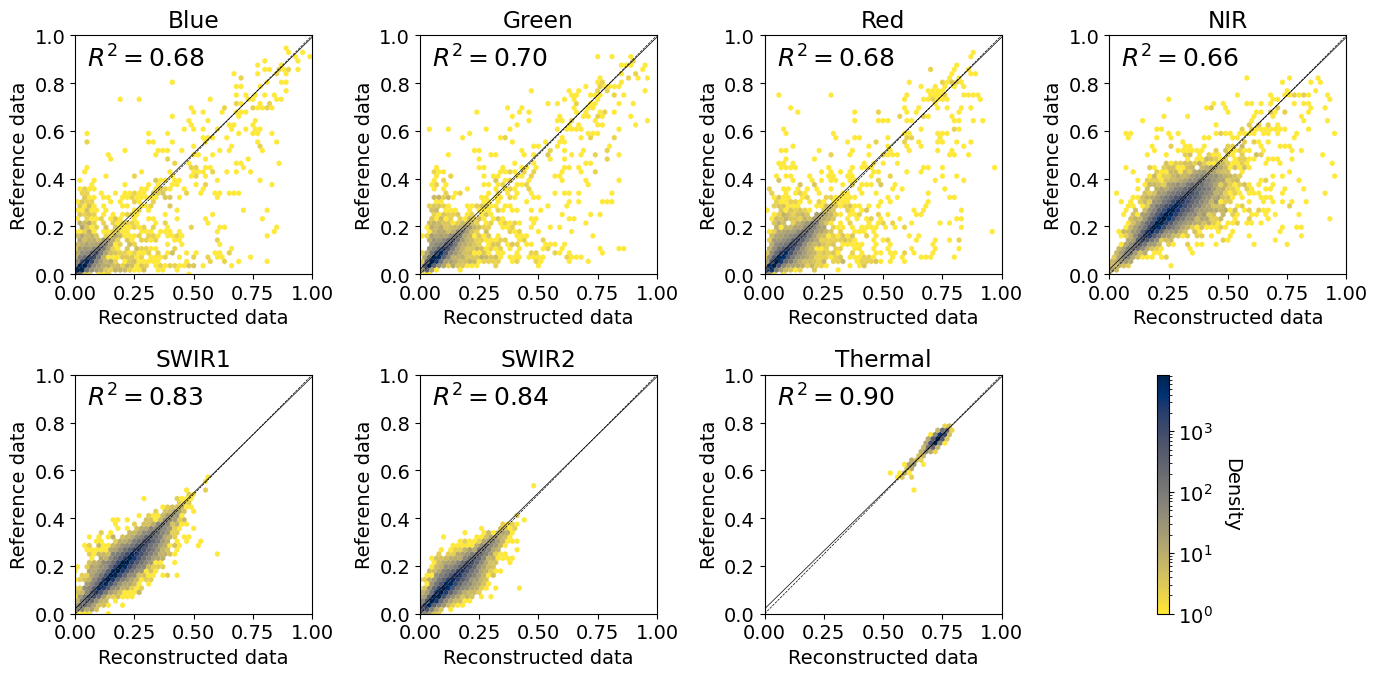

CPU times: user 22.4 s, sys: 852 ms, total: 23.2 s
Wall time: 3.39 s


In [10]:
%%time
nan_fraction_vec = np.linspace(0,1,13)[1:-2]
n_bands = 7

use_future = 0
w_l = 2
p_o = 2
coef = savgol_coeffs(w_l*2+1, p_o, use='dot')
n_t_tot_1c = merged_agg_data_1c.shape[0]
n_t_tot_0c = merged_agg_data_0c.shape[0]
n_t_tot_ge2c = merged_agg_data_ge2c.shape[0]
n_t_1c = int(n_t_tot_1c/n_bands)
n_t_0c = int(n_t_tot_0c/n_bands)
n_t_ge2c = int(n_t_tot_ge2c/n_bands)
n_s = merged_agg_data_1c.shape[1]

out_vec = ()
bands = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'Thermal']

# Create a figure and axis objects
fig, axs = plt.subplots(2, 4, figsize=(14, 7))

for i, ax in enumerate(axs.flat):
    if i < len(bands):
        k = i  # index for bands
        data_tmp = np.concatenate((merged_agg_data_1c[k*n_t_1c:(k+1)*n_t_1c,:], \
                                   merged_agg_data_ge2c[k*n_t_ge2c:(k+1)*n_t_ge2c,:], \
                                   merged_agg_data_0c[k*n_t_0c:(k+1)*n_t_0c,:]), axis=0)
        n_t = data_tmp.shape[0]      
        data_ref = np.zeros((1, n_t, n_s))
        data_ref[0,:,:] = data_tmp.copy()

        nan_fraction = nan_fraction_vec[0]
        data = add_nan_elements(data_ref, nan_fraction)

        wv_p_prod = get_SWA_weights(46, 45, 6, n_s)[1:][::-1]
        wv_f_prod = get_SWA_weights(46, 45, 6, n_s)[1:]*use_future
        TsirfTransformer_prod = process.TsirfTransformer(wv_0=1, wv_f=wv_f_prod, wv_p=wv_p_prod, backend="dense", use_mask=True, return_den=True)
        out_prod, mask_prod = TsirfTransformer_prod._run(data)

        mask_cmp = np.isnan(data) & ~np.isnan(data_ref)
        mask_cmp = mask_cmp & ~np.isnan(out_prod)
        masked_data_ref = data_ref[mask_cmp]
        masked_out_prod = out_prod[mask_cmp]


        corr_matrix = np.corrcoef(masked_data_ref, masked_out_prod)
        corr = corr_matrix[0, 1]
        R_sq = corr**2
        lm = LinearRegression()
        lm.fit(reconstructed_data.reshape(-1, 1), original_data)

        diag = np.linspace(0, 1, 1000)
        ax.plot(diag, lm.intercept_ + diag * lm.coef_[0], color='black', linewidth=0.5)
        ax.plot(diag, diag, '--', color='black', linewidth=0.5)

        # Hexbin plot
        hb = ax.hexbin(
            masked_data_ref.flatten(),
            masked_out_prod.flatten(),
            gridsize=50,
            bins='log', 
            cmap='cividis_r', 
            mincnt=1,
            extent=[0, 1, 0, 1],
            linewidths=0.1
        )
        
        ax.text(0.05, 0.87, f'$R^2={R_sq:.2f}$', fontsize=18)
        ax.set_ylim((0, 1))
        ax.set_xlim((0, 1))
        ax.set_title(bands[k], y=1.0)
        ax.set_xlabel('Reconstructed data')
        ax.set_ylabel('Reference data')
    else:
        ax.axis('off')  # Turn off empty subplot

# Add color bar in the bottom-right (8th subplot position)
cbar_ax = axs[1, 3]  # Select the bottom-right subplot (empty space)
cbar = fig.colorbar(hb, ax=cbar_ax, orientation='vertical', fraction=0.8, pad=0.1)
cbar.set_label('Density', rotation=270, labelpad=20)  # Title at side of color bar
cbar_ax.axis('off')  # Hide plot frame for the colorbar area

# Adjust layout
plt.tight_layout()

# Save and show the plot
plt.savefig('scatter_bands_hexbin.png', dpi=400, bbox_inches="tight")
plt.show()


## Compare different error metrics per band

In [11]:
%%time
nan_fraction_vec = np.linspace(0,1,13)[1:-2]
n_methods = 5
n_bands = 7
n_iter = 3
RMSE = np.zeros((n_bands, n_iter), np.double)
CVRMSE = np.zeros((n_bands, n_iter), np.double)
RMSE_std = np.zeros((n_bands, n_iter), np.double)
R_sq = np.zeros((n_bands, n_iter), np.double)
CCC = np.zeros((n_bands, n_iter), np.double)
tot_nan_fracs = np.zeros((len(nan_fraction_vec), n_bands+2, n_iter), np.double)

use_future = 0
w_l = 2
p_o = 2
coef = savgol_coeffs(w_l*2+1, p_o, use='dot')
n_t_tot_1c = merged_agg_data_1c.shape[0]
n_t_tot_0c = merged_agg_data_0c.shape[0]
n_t_tot_ge2c = merged_agg_data_ge2c.shape[0]
n_t_1c = int(n_t_tot_1c/n_bands)
n_t_0c = int(n_t_tot_0c/n_bands)
n_t_ge2c = int(n_t_tot_ge2c/n_bands)
n_s = merged_agg_data_1c.shape[1]
nan_fraction = 0.1
for it in range(n_iter):
    for k in range(n_bands):
        data_tmp = np.concatenate((merged_agg_data_1c[k*n_t_1c:(k+1)*n_t_1c,:], \
                                   merged_agg_data_ge2c[k*n_t_ge2c:(k+1)*n_t_ge2c,:], \
                                   merged_agg_data_0c[k*n_t_0c:(k+1)*n_t_0c,:]), axis=0)
        n_t = data_tmp.shape[0]      
        data_ref = np.zeros((1, n_t, n_s))
        data_ref[0,:,:] = data_tmp.copy()
        data = add_nan_elements(data_ref, nan_fraction)
        wv_p_prod = get_SWA_weights(46, 45, 6, n_s)[1:][::-1]
        wv_f_prod = get_SWA_weights(46, 45, 6, n_s)[1:]*use_future
        TsirfTransformer_prod = process.TsirfTransformer(wv_0=1, wv_f=wv_f_prod, wv_p=wv_p_prod, backend="dense", use_mask=True, return_den=True)
        out_prod, mask_prod = TsirfTransformer_prod._run(data)
        out_vec = (out_prod, )
        RMSE[k,it] = compute_RMSE(out_vec, data, data_ref)[0]
        CVRMSE[k,it] = compute_CVRMSE(out_vec, data, data_ref)[0]
        RMSE_std[k,it] = compute_RMSE_std(out_vec, data, data_ref)[0]
        R_sq[k,it] = compute_R_sq(out_vec, data, data_ref)[0]
        CCC[k,it] = compute_CCC(out_vec, data, data_ref)[0]
        
        
RMSE = np.mean(RMSE, -1)
CVRMSE = np.mean(CVRMSE, -1)
RMSE_std = np.mean(RMSE_std, -1)
R_sq = np.mean(R_sq, -1)
CCC = np.mean(CCC, -1)


CPU times: user 47.5 s, sys: 1.65 s, total: 49.2 s
Wall time: 1.47 s


In [12]:
print("RMSE")
print(RMSE)
print("CVRMSE")
print(CVRMSE)
print("RMSE_std")
print(RMSE_std)
print("R_sq")
print(R_sq)
print("CCC")
print(CCC)

RMSE
[0.04056866 0.04057281 0.04304718 0.04864619 0.02905818 0.02483043
 0.00506947]
CVRMSE
[0.88508599 0.5244385  0.54031585 0.19496934 0.15072963 0.21891787
 0.00695538]
RMSE_std
[0.59252893 0.58667763 0.56108115 0.5984398  0.41425347 0.40819871
 0.32229515]
R_sq
[0.65265211 0.65935067 0.68796218 0.64667035 0.82940265 0.83484714
 0.8968725 ]
CCC
[0.799244   0.80425344 0.8226005  0.79667048 0.9091076  0.91254141
 0.94670519]


# Stratified comparison

In [13]:
import pyreadr
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
sys.path.insert(0, os.path.abspath('../../'))
from skmap.data import toy
from skmap.io import process
import importlib
import time
importlib.reload(process)
from tqdm.notebook import tqdm
from scipy.signal import savgol_coeffs

In [15]:
bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermal']

u_strata = np.unique(strata)
u_strata = np.delete(u_strata, 1, 0)

n_strata = len(u_strata)
RMSE_mat = np.zeros((7,n_strata))
tot_nan_fracs = np.zeros((n_strata,))

nan_fraction = 0.1
clear_mat = pyreadr.read_r('clear_agg.rds')[None].to_numpy()
clear_mat = clear_mat[mask]
for i, band in enumerate(bands):
    band_mat = pyreadr.read_r(f'{band}_agg.rds')[None].to_numpy()/250.
    band_mat = band_mat[mask]
    print(f"Band {band}")
    print(f"Stratum: ", end="")
    for j, stratum in enumerate(u_strata):
        print(f"{stratum}, ", end="")
        if stratum == 1:
            agg_nogap_mask_1 = (clear_mat[strata==1,:] == 1)    
            data_tmp_1 = band_mat[strata==1,:]
            n_t = data_tmp_1.shape[0]
            n_s = data_tmp_1.shape[1]
            agg_nogap_mask_2 = (clear_mat[strata==2,:] == 1)    
            data_tmp_2 = band_mat[strata==2,:]
            agg_nogap_mask = np.zeros((n_t, n_s), bool)
            data_tmp = np.zeros((n_t, n_s), np.double)
            cut = int(n_t*0.97)
            agg_nogap_mask[0:cut,:] = agg_nogap_mask_1[0:cut,:]
            agg_nogap_mask[cut:,:] = agg_nogap_mask_2[0:n_t-cut,:]
            data_tmp[0:cut,:] = data_tmp_1[0:cut,:]
            data_tmp[cut:,:] = data_tmp_2[0:n_t-cut,:]
        else:
            agg_nogap_mask = (clear_mat[strata==stratum,:] == 1)    
            data_tmp = band_mat[strata==stratum,:]            
        data_tmp[~agg_nogap_mask] = np.nan
        n_t = data_tmp.shape[0]
        n_s = data_tmp.shape[1]
        data_ref = np.zeros((1, n_t, n_s))
        data_ref[0,:,:] = data_tmp.copy()
        data = add_nan_elements(data_ref, nan_fraction)
        tot_nan_fracs[j] = np.sum(np.isnan(data).astype(int))/data.size

        wv_p_prod = get_SWA_weights(46, 45, 6, n_s)[1:][::-1]
        wv_f_prod = get_SWA_weights(46, 45, 6, n_s)[1:]*0.0
        TsirfTransformer_prod = process.TsirfTransformer(wv_0=1, wv_f=wv_f_prod, wv_p=wv_p_prod, backend="dense", use_mask=True)
        out_prod = TsirfTransformer_prod._run(data)
        
        RMSE_mat[i,j] = compute_RMSE((out_prod,), data, data_ref)[0]
    print(f" ")

    
    


Band blue
Stratum: 1, 10, 20, 30, 50, 60, 70, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  
Band green
Stratum: 1, 10, 20, 30, 50, 60, 70, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  
Band red
Stratum: 1, 10, 20, 30, 50, 60, 70, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  
Band nir
Stratum: 1, 10, 20, 30, 50, 60, 70, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  
Band swir1
Stratum: 1, 10, 20, 30, 50, 60, 70, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  
Band swir2
Stratum: 1, 10, 20, 30, 50, 60, 70, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  
Band thermal
Stratum: 1, 10, 20, 30, 50, 60, 70, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  


## Legend of ESA-CCI at https://maps.elie.ucl.ac.be/CCI/viewer/download/CCI-LC_Maps_Legend.pdf

In [16]:
ticks = ['1','10','20','30','50','60','70','80','90','100','120','130','140','150','160','180','190','200','220','300']
ticks = [int(ii) for ii in ticks]
ticks_orig = ['Land cover change','Rainfed crop','Irrigated crop','Mosaic crop-nat.veg.','Everg. broadl. tree','Dec. broadl. tree','Everg. needl. tree','Dec. needl. tree', \
         'Mix broadl.-needl.','Mosaic t.-shrub-herb.','Shrubland','Grassland','Lichens-mosses','Sparse vegetation','Flooded tree cover','Flooded schrub-herb.','Urban areas','Bare areas','Permanent snow-ice']

strata_df = pd.DataFrame(columns=['label','count'])

counts = []
for ii in range(len(ticks)-1):
    msk = (strata<ticks[ii+1]) & (strata>=ticks[ii])
    counts.append(np.sum(msk))
    
strata_df['label'] = ticks_orig
strata_df['count'] = counts
strata_df['code'] = ticks[0:-1]
print('strata distribution')
strata_df

strata distribution


,label,count,code
0,Land cover change,221,1
1,Rainfed crop,316,10
2,Irrigated crop,138,20
3,Mosaic crop-nat.veg.,146,30
4,Everg. broadl. tree,19,50
5,Dec. broadl. tree,131,60
6,Everg. needl. tree,273,70
7,Dec. needl. tree,0,80
8,Mix broadl.-needl.,234,90
9,Mosaic t.-shrub-herb.,271,100


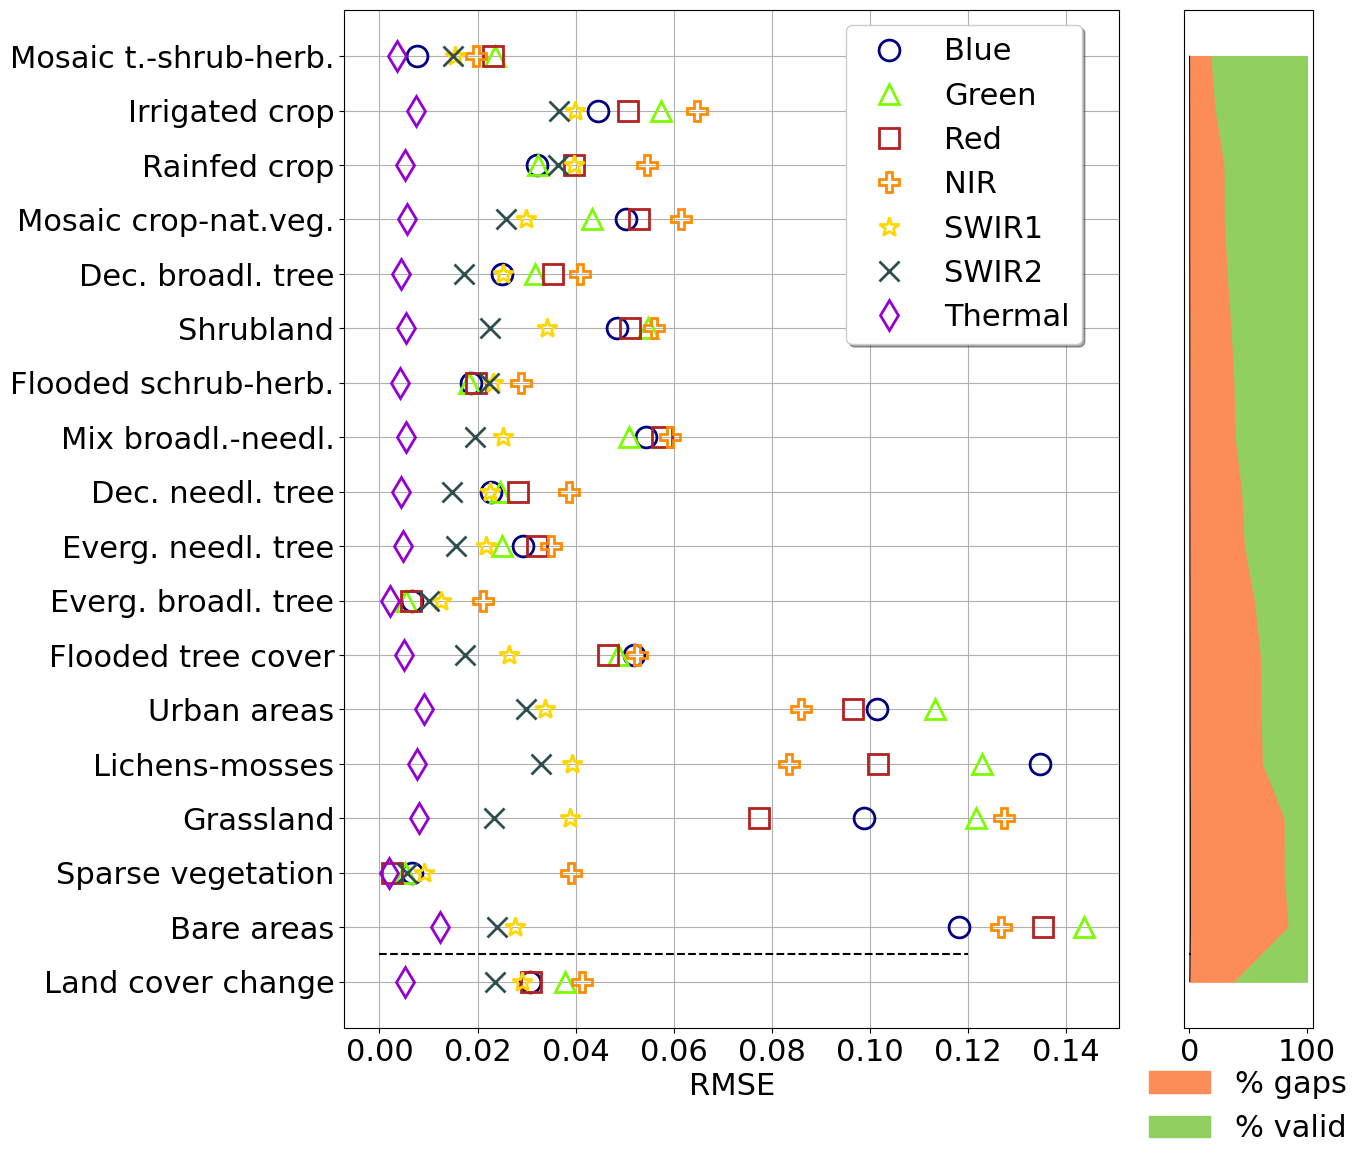

In [17]:
import matplotlib.lines as mlines
font_size = 22
plt.rc('font', size=font_size)
plt.rc('axes', titlesize=font_size)
plt.rc('axes', labelsize=font_size)
plt.rc('xtick', labelsize=font_size)    
plt.rc('ytick', labelsize=font_size)   
plt.rc('legend', fontsize=font_size) 
plt.rc('figure', titlesize=font_size)  
fig = plt.figure(figsize=(14,12))
grid = plt.GridSpec(1, 2, width_ratios=[6, 1])
ax1 = plt.subplot(grid[0])
ax2 = plt.subplot(grid[1])
order = np.argsort(tot_nan_fracs)[::-1]
range_arr = np.arange(order.size)  
tmp = order[np.where(order==0)[0][0]]
order[range_arr != 0 ] = order[range_arr != np.where(order==0)[0][0]]
order[0] = tmp
ms = 15
mw = 2
bands = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'Thermal']
marker_list = ['o', '^', 's', 'P', '*', 'x', 'd']
color_list = ['navy', 'lawngreen', 'firebrick', 'darkorange', 'gold', 'darkslategray', 'darkviolet']
# ticks = ['1','2','10','20','30','50','60','70','80','90','100','120','130','140','150','160','180','190','200','220']
ticks_orig = ['Land cover change','Rainfed crop','Irrigated crop','Mosaic crop-nat.veg.','Everg. broadl. tree','Dec. broadl. tree','Everg. needl. tree','Dec. needl. tree', \
         'Mix broadl.-needl.','Mosaic t.-shrub-herb.','Shrubland','Grassland','Lichens-mosses','Sparse vegetation','Flooded tree cover','Flooded schrub-herb.','Urban areas','Bare areas','Permanent snow-ice']
handles = []
ticks = []

for i, band in enumerate(bands):
    handles.append(mlines.Line2D([], [], color=color_list[i], marker=marker_list[i], linestyle='None', markeredgewidth=mw, 
                          markersize=ms,  mfc='none', label=bands[i]))
    for k, j in enumerate(order):
        if i == 0:
            ticks.append(ticks_orig[j])
        ax1.plot(RMSE_mat[i,j], k, marker=marker_list[i],  markersize=ms,  mfc='none', color=color_list[i], markeredgewidth=mw)
ax1.set_xlabel('RMSE')
ax1.hlines(0.5,0,0.12,'k',linestyles='dashed')
ax1.set_yticks(range(n_strata), ticks, fontdict=None, minor=False)
ax1.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.80, 1),
          ncol=1, fancybox=True, shadow=True)
ax1.grid()
plt.subplot(1, 2, 2)
n = len(tot_nan_fracs[order])
ax2.plot(tot_nan_fracs[order], range(n), color='k', linewidth=0.7)
ax2.fill_betweenx(range(n), tot_nan_fracs[order]*100, 0.0, color='#fc8d59',  label='% gaps')
ax2.fill_betweenx(range(n), tot_nan_fracs[order]*100, 100, color='#91cf60', label='% valid')
ax2.set_yticks([])
ax2.hlines(0.5,0,1,'k',linestyles='dashed')
ax2.set_xlabel('Gaps')
leg = ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.023), ncol=1, fancybox=False, shadow=False, borderpad=0.1)
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_alpha(None)
plt.tight_layout()
plt.savefig('ESACCI_RMSE.pdf', format="pdf", bbox_inches="tight")
plt.show()